In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab13.ipynb")

# Lab 13: Decision Trees and Random Forests



In [2]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree

# you may get a warning from importing ensemble. It is OK to ignore said warning
from sklearn import ensemble

plt.style.use('fivethirtyeight')

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Objectives

In this assignment, we will have you train a multi-class classifier with three different models (one-vs-rest logistic regression, decision trees, random forests) and compare the accuracies and decision boundaries created by each. 

<br/><br/>

## [Tutorial] Dataset, EDA, and Classification Task
We'll be looking at a dataset of per-game stats for all NBA players in the 2018-19 season. This dataset comes from [basketball-reference.com](https://www.basketball-reference.com/).

In [3]:
# just run this cell

nba_data = pd.read_csv("nba18-19.csv")
nba_data.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


Our goal will be to predict a player's **position** given several other features. The 5 positions in basketball are PG, SG, SF, PF, and C (which stand for point guard, shooting guard, small forward, power forward, and center; [Wikipedia](https://en.wikipedia.org/wiki/Basketball_positions)).

This information is contained in the `Pos` column:

In [4]:
nba_data['Pos'].value_counts()

Pos
SG       176
PF       147
PG       139
C        120
SF       118
PF-SF      2
SF-SG      2
SG-PF      1
C-PF       1
SG-SF      1
PF-C       1
Name: count, dtype: int64

There are several features we could use to predict this position; check the [Basketball statistics](https://en.wikipedia.org/wiki/Basketball_statistics) page of Wikipedia for more details on the statistics themselves.

In [5]:
nba_data.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In this lab, we will restrict our exploration to two inputs: [Rebounds](https://en.wikipedia.org/wiki/Rebound_(basketball)) (`TRB`) and [Assists](https://en.wikipedia.org/wiki/Assist_(basketball)) (`AST`). Two-input feature models will make our 2-D visualizations more straightforward.

<br/>

### 3-class classification

While we could set out to try and perform 5-class classification, the results (and visualizations) are slightly more interesting if we try and categorize players into 1 of 3 categories: **Guard**, **Forward**, and **Center**. The below code will take the `Pos` column of our dataframe and use it to create a new column `Pos3` that consist of values `'G'`, `'F'`, and `'C'` (which stand for Guard, Forward, and Center).

In [6]:
# just run this cell
def basic_position(pos):
    if 'F' in pos:
        return 'F'
    elif 'G' in pos:
        return 'G'
    return 'C'

nba_data['Pos3'] = nba_data['Pos'].apply(basic_position)
nba_data['Pos3'].value_counts()

Pos3
G    315
F    273
C    120
Name: count, dtype: int64

<br/><br/>

### Data Cleaning and Visualization

Furthermore, since there are **many** players in the NBA (in the 2018-19 season there were 530 unique players), our visualizations can get noisy and messy. Let's restrict our data to only contain rows for players that averaged 10 or more points per game.

In [7]:
# just run this cell
nba_data = nba_data[nba_data['PTS'] > 10]

Now, let's look at a scatterplot of Rebounds (`TRB`) vs. Assists (`AST`).

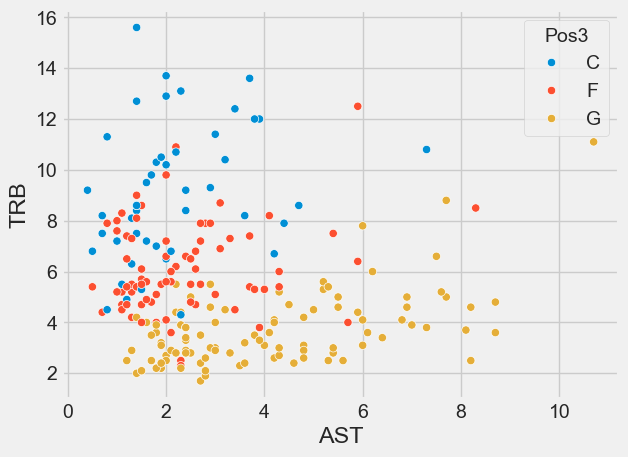

In [8]:
sns.scatterplot(data = nba_data, x = 'AST', y = 'TRB', hue = 'Pos3');

As you can see, when using just rebounds and assists as our features, we see pretty decent cluster separation. That is, Guards, Forward, and Centers appear in different regions of the plot.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Evaluating Split Quality

We will explore different ways to evaluate split quality for classification and regression trees in this question.

<br/>

---

### Question 1a: Entropy

In lecture we defined the entropy $S$ of a node as:

$$ S = -\sum_{C} p_C \log_{2} p_C $$

where $p_C$ is the proportion of data points in a node with label $C$. This function is a measure of the unpredictability of a node in a decision tree. 

Implement the `entropy` function, which outputs the entropy of a node with a given set of labels. The `labels` parameter is a list of labels in our dataset. For example, `labels` could be `['G', 'G', 'F', 'F', 'C', 'C']`.

<!--
BEGIN QUESTION
name: q1a
-->

In [9]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    ps = counts / counts.sum()
    return -np.sum(ps * np.log2(ps))

entropy(nba_data['Pos3'])

1.521555567956027

In [10]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

---

### Question 1b: Gini impurity

Another metric for determining the quality of a split is **Gini impurity**. This is defined as the chance that a sample would be misclassified if randomly assigned at this point. Gini impurity is a popular alternative to entropy for determining the best split at a node, and it is in fact the default criterion for scikit-learn's `DecisionTreeClassifier`.

We can calculate the Gini impurity of a node with the formula ($p_C$ is the proportion of data points in a node with label $C$):

$$ G = 1 - \sum_{C} {p_C}^2 $$

Note that no logarithms are involved in the calculation of Gini impurity, which can make it faster to compute compared to entropy.

Implement the `gini_impurity` function, which outputs the Gini impurity of a node with a given set of labels. The `labels` parameter is defined similarly to the previous part.

<!--
BEGIN QUESTION
name: q1b
-->

In [11]:
def gini_impurity(labels):
    _, counts = np.unique(labels, return_counts=True)
    ps = counts / counts.sum()
    return 1 - np.sum(ps**2)

gini_impurity(nba_data['Pos3'])

0.6383398017253514

In [12]:
grader.check("q1b")

q1b results: All test cases passed!

As an optional exercise in probability, try to think of a way to derive the formula for Gini impurity.

<br/>

---

### [Tutorial] Variance

Are there other splitting metrics beyond entropy and Gini impurity? Yes! A third metric is **variance** (yes, that variance), which is often used for **regression trees**, or **decision tree regressors**, which split data based on a continuous response variable. It makes little sense to use entropy/Gini impurity for regression, as both metrics assume that there are discrete probabilities of responses (and therefore are more suited to classification).

Recall that the variance is defined as:

$$ \sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 $$

where $\mu$ is the mean, $N$ is the total number of data points, and $x_i$ is the value of each data point.

Run the below cell to define the `variance` function.

In [13]:
# just run this cell
def variance(values):
    return np.mean((values - np.mean(values)) ** 2)
    
# if we were predicting # points scored per player (regression)
variance(nba_data['PTS'])

21.023148263588652

<br/>

---

### Question 1c: Weighted Metrics

In lecture, we used **weighted entropy** as a loss function to help us determine the best split. Recall that the weighted entropy is given by:

$$ L = \frac{N_1 S(X) + N_2 S(Y)}{N_1 + N_2} $$

$N_1$ is the number of samples in the left node $X$, and $N_2$ is the number of samples in the right node $Y$. This notion of a weighted average can be extended to other metrics such as Gini impurity and variance simply by changing the $S$ (entropy) function to $G$ (Gini impurity) or $\sigma^2$ (variance).

First, implement the `weighted_metric` function. The `left` parameter is a list of labels or values in the left node $X$, and the `right` parameter is a list of labels or values in the right node $Y$. The `metric` parameter is a function which can be `entropy`, `gini_impurity`, or `variance`. For `entropy` and `gini_impurity`, you may assume that `left` and `right` contain discrete labels. For `variance`, you may assume that `left` and `right` contain continuous values.

Then, assign `we_pos3_age_30` to the weighted entropy (in the `Pos3` column) of a split that partitions `nba_data` into two groups: a group with players who are 30 years old or older and a group with players who are younger than 30 years old.

<!--
BEGIN QUESTION
name: q1c
-->

In [14]:
nba_data['Pos3']

3      C
7      C
10     C
19     F
21     F
      ..
695    G
698    F
699    G
700    C
703    C
Name: Pos3, Length: 223, dtype: object

In [15]:
def weighted_metric(left, right, metric):
    return (len(left) * metric(left) + len(right) * metric(right)) / (len(left) + len(right))

we_pos3_age_30 = weighted_metric(nba_data.loc[nba_data['Age']>=30, 'Pos3'], nba_data.loc[nba_data['Age'] < 30, 'Pos3'], entropy)
we_pos3_age_30

1.521489768014793

In [16]:
grader.check("q1c")

q1c results: All test cases passed!

We will not go over the entire decision tree fitting process in this assignment, but you now have the basic tools to fit a decision tree. As an optional exercise, try to think about how you would extend these tools to fit a decision tree from scratch.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Question 2: Classification

Let's switch gears to classification.

Before fitting any models, let's first split `nba_data` into a training set and test set.


In [17]:
# just run this cell
nba_train, nba_test = train_test_split(nba_data, test_size=0.25, random_state=100)
nba_train = nba_train.sort_values(by='Pos')
nba_test = nba_test.sort_values(by='Pos')

<br/><br/>

<hr style="border: 1px solid #fdb515;" />

## One-vs-Rest Logistic Regression

We only discussed binary logistic regression in class, but there is a natural extension to binary logistic regression called one-vs-rest logistic regression for multiclass classification. In essence, one-vs-rest logistic regression simply builds one binary logistic regression classifier for each of the $N$ classes (in this scenario $N = 3$). We then predict the class corresponding to the classifier that gives the highest probability among the $N$ classes.


### Question 2a

In the cell below, set `logistic_regression_model` to be a one-vs-rest logistic regression model. Then, fit that model using the `AST` and `TRB` columns (in that order) from `nba_train` as our features, and `Pos3` as our response variable.

Remember, `sklearn.linear_model.LogisticRegression` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) has already been imported for you. There is an optional parameter **`multi_class`** you need to specify in order to make your model a multi-class one-vs-rest classifier. See the documentation for more details.

<!--
BEGIN QUESTION
name: q2a
-->

In [18]:
logistic_regression_model = LogisticRegression(multi_class='ovr')
logistic_regression_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [19]:
grader.check("q2a")

q2a results: All test cases passed!

<br/><br/>

### [Tutorial] Visualizing Performance

To see our classifier in action, we can use `logistic_regression_model.predict` and see what it outputs.

In [20]:
# just run this cell
nba_train['Predicted (OVRLR) Pos3'] = logistic_regression_model.predict(nba_train[['AST', 'TRB']])
nba_train[['AST', 'TRB', 'Pos3', 'Predicted (OVRLR) Pos3']].head(15)

,AST,TRB,Pos3,Predicted (OVRLR) Pos3
655,1.4,8.6,C,C
644,2.0,10.2,C,C
703,0.8,4.5,C,F
652,1.6,7.2,C,F
165,1.4,7.5,C,C
122,2.4,8.4,C,C
353,7.3,10.8,C,C
367,1.4,8.6,C,C
408,1.2,4.9,C,F
161,3.9,12.0,C,C


Our model does decently well here, as you can see visually above. Below, we compute the training accuracy; remember that `model.score()` computes accuracy.

In [21]:
lr_training_accuracy = logistic_regression_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
lr_training_accuracy

0.7964071856287425

We can compute the test accuracy as well by looking at `nba_test` instead of `nba_train`:

In [22]:
lr_test_accuracy = logistic_regression_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
lr_test_accuracy

0.6428571428571429

Now, let's draw the decision boundary for this logistic regression classifier, and see how the classifier performs on both the training and test data.

In [23]:
# just run this cell to save the helper function
def plot_decision_boundaries(model, nba_dataset, title=None, ax=None):
    sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

    xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
    Z_string = model.predict(np.c_[xx.ravel(), yy.ravel()])
    categories, Z_int = np.unique(Z_string, return_inverse = True)
    Z_int = Z_int.reshape(xx.shape)
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
        
    ax.contourf(xx, yy, Z_int, cmap = sns_cmap)
    
    sns.scatterplot(data = nba_dataset, x = 'AST', y = 'TRB', hue = 'Pos3', ax=ax)

    if title is not None:
        ax.set_title(title)

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


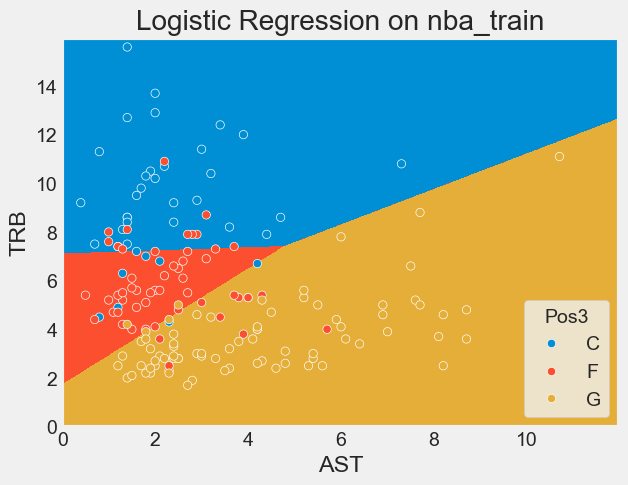

In [24]:
# just run this cell
plot_decision_boundaries(logistic_regression_model, nba_train, "Logistic Regression on nba_train")

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


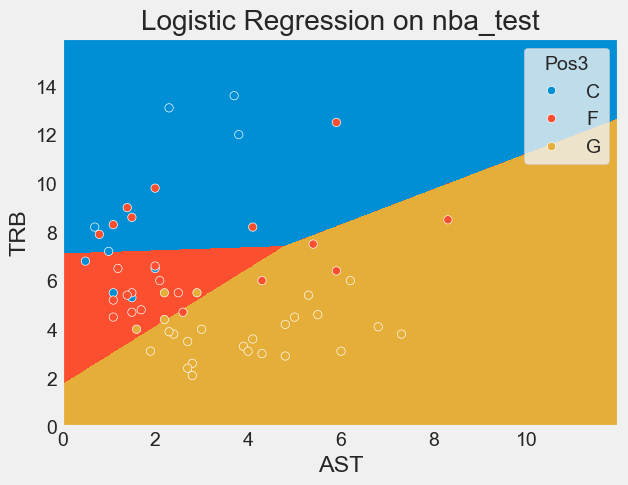

In [25]:
# just run this cell
plot_decision_boundaries(logistic_regression_model, nba_test, "Logistic Regression on nba_test")

Our one-vs-rest logistic regression was able to find a linear decision boundary between the three classes. It generally classifies centers as players with a lot of rebounds, forwards as players with a medium number of rebounds and a low number of assists, and guards as players with a low number of rebounds. 

Note: In practice we would use many more features – we only used 2 here just so that we could visualize the decision boundary.

<br/>
<br/>

<hr style="border: 1px solid #fdb515;" />

## Decision Trees

### Question 2b

Let's now create a decision tree classifier on the same training data `nba_train`, and look at the resulting decision boundary. 

In the following cell, first, use `tree.DecisionTreeClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) to fit a model using the same features and response as above, and call this model `decision_tree_model`. Set the `random_state` and `criterion` parameters to 42 and `entropy`, respectively.

**Hint:** Your code will be mostly the same as the previous part.

<!--
BEGIN QUESTION
name: q2b
-->

In [26]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy')
decision_tree_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])
# logistic_regression_model = LogisticRegression(multi_class='ovr')
# logistic_regression_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [27]:
grader.check("q2b")

q2b results: All test cases passed!

### [Tutorial] Decision Tree Performance

Now, let's draw the decision boundary for this decision tree classifier, and see how the classifier performs on both the training and test data.

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


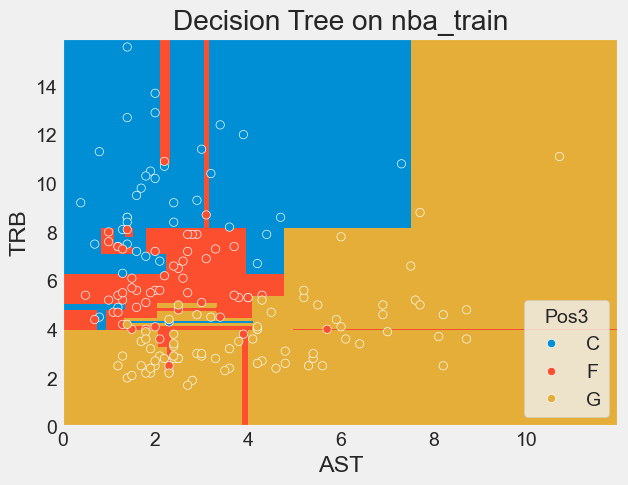

In [28]:
# just run this cell
plot_decision_boundaries(decision_tree_model, nba_train, "Decision Tree on nba_train")

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


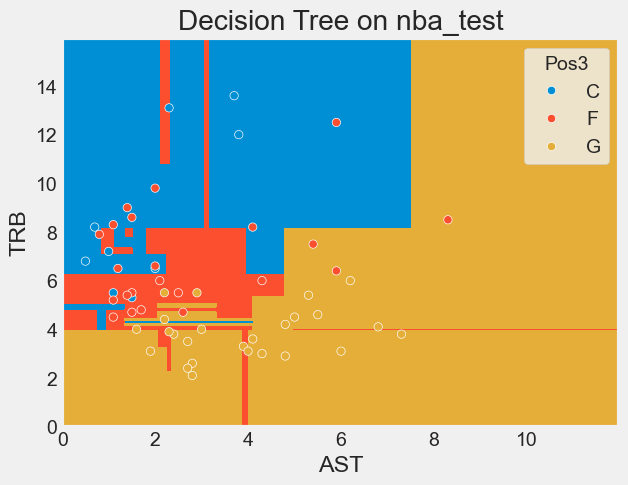

In [29]:
# just run this cell
plot_decision_boundaries(decision_tree_model, nba_test, "Decision Tree on nba_test")

We compute the training and test accuracies of the decision tree model below.

In [30]:
dt_training_accuracy = decision_tree_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
dt_test_accuracy = decision_tree_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
dt_training_accuracy, dt_test_accuracy

(0.9940119760479041, 0.5714285714285714)

<br/>
<br/>

<hr style="border: 1px solid #fdb515;" />

## Random Forests

### Question 2c

Let's now create a random forest classifier on the same training data `nba_train` and look at the resulting decision boundary. 

In the following cell, use `ensemble.RandomForestClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) to fit a model using the same features and response as above, and call this model `random_forest_model`. Use 20 trees in your random forest classifier; set the `random_state` and `criterion` parameters to 42 and `entropy`, respectively.

**Hint:** Your code for both parts will be mostly the same as the first few parts of this question.

**Hint:** Look at the `n_estimators` parameter of `ensemble.RandomForestClassifier`.

<!--
BEGIN QUESTION
name: q2c
-->

In [31]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators=20, random_state=42, criterion='entropy')
random_forest_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [32]:
grader.check("q2c")

q2c results: All test cases passed!

### [Tutorial] Random Forest Performance

Now, let's draw the decision boundary for this random forest classifier, and see how the classifier performs on both the training and test data.

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


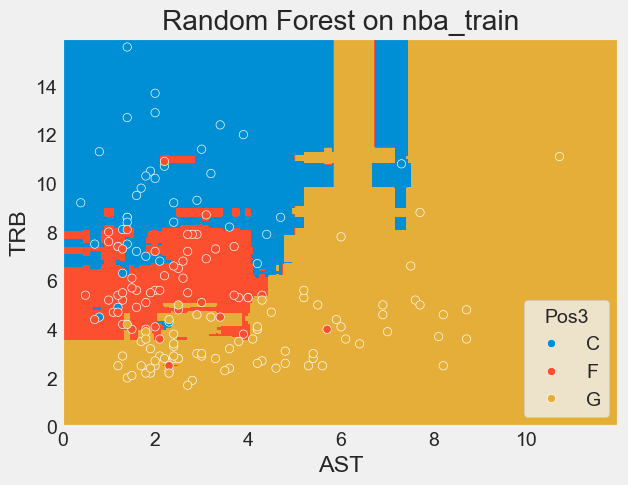

In [33]:
# just run this cell
plot_decision_boundaries(random_forest_model, nba_train, "Random Forest on nba_train")

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


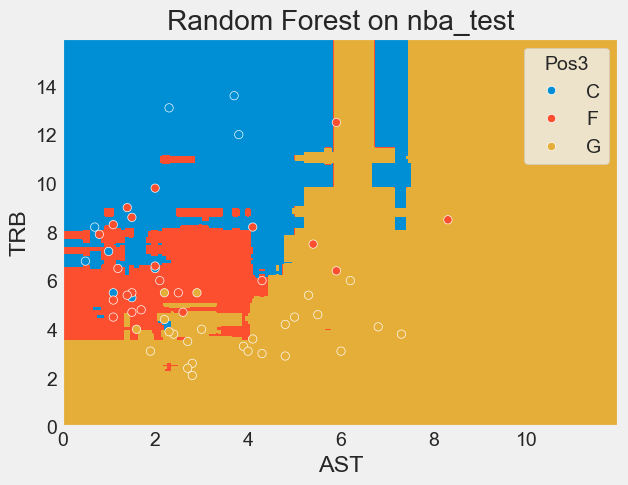

In [34]:
# just run this cell
plot_decision_boundaries(random_forest_model, nba_test, "Random Forest on nba_test")

We compute the training and test accuracies of the random forest model below.

In [35]:
# just run this cell
rf_train_accuracy = random_forest_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
rf_test_accuracy = random_forest_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
rf_train_accuracy, rf_test_accuracy

(0.9760479041916168, 0.6964285714285714)

<br/>
<br/>

<hr style="border: 1px solid #fdb515;" />

## Compare/Contrast

How do the three models you created (multiclass one-vs-rest logistic regression, decision tree, random forest) compare to each other?)

**Decision boundaries**: Run the below cell for your convenience. It overlays the decision boundaries for the train and test sets for each of the models you created.

C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\24349\.conda\envs\ds100\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\24349\.conda\envs\d

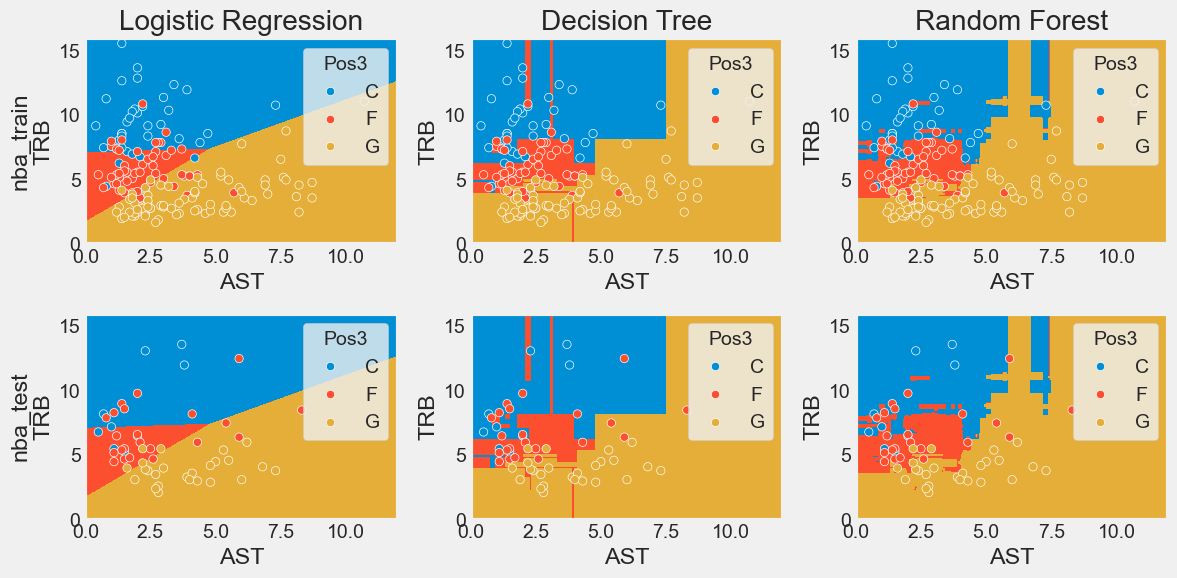

In [36]:
# just run this cell

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for j, (model, title) in enumerate([(logistic_regression_model, "Logistic Regression"),
                                    (decision_tree_model, "Decision Tree"),
                                    (random_forest_model, "Random Forest")]):
    axs[0, j].set_title(title)
    for i, nba_dataset in enumerate([nba_train, nba_test]):
        plot_decision_boundaries(model, nba_dataset, ax=axs[i, j])
        
# reset leftmost ylabels
axs[0, 0].set_ylabel("nba_train\nTRB")
axs[1, 0].set_ylabel("nba_test\nTRB")
fig.tight_layout()

**Performance Metrics**: Run the below cell for your convenience. It summarizes the train and test accuracies for the three models you created.

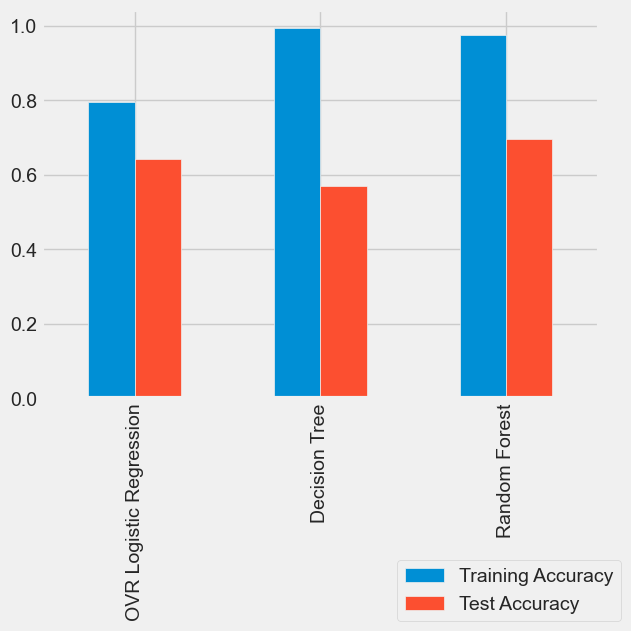

In [37]:
# just run this cell
train_accuracy = [lr_training_accuracy, lr_test_accuracy, dt_training_accuracy, dt_test_accuracy, rf_train_accuracy, rf_test_accuracy]
index = ['OVR Logistic Regression', 'Decision Tree', 'Random Forest']
df = pd.DataFrame([(lr_training_accuracy, lr_test_accuracy), 
                   (dt_training_accuracy, dt_test_accuracy),
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'], index=index)
df.plot.bar();
plt.legend().remove() # remove legend from plot itself
plt.gcf().legend(loc='lower right') # and add legend to bottom of figure

---

### Question 2d


Looking at the three models, which model performed the best on the training set, and which model performed the best on the test set? How are the training and test accuracy related for the three models, and how do the decision boundaries generated for each of the three models relate to the model's performance?

<!--
BEGIN QUESTION
name: q2d
-->

_DT_

_OVRLR_

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# [ungraded] Question 3: Regression Trees

In Project 1, we used linear regression to predict housing prices in Cook County, Illinois. However, what would happen if we tried to use a different prediction method?

Try fitting a **regression tree** (also known as a decision tree regressor) to predict housing prices. Here's one in sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

What do you notice about the training error and the test error for the decision tree regressor? Is one significantly larger than the other? If so, what methods could we use to make this error lower?

Now, try fitting a random forest regressor instead of a single decision tree. What do you notice about the training error and the test error for the random forest, and how does this compare to the training and test error of a single decision tree?

_see in project 1_

# Congratulations! You finished the lab!

---


In [38]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2c results: All test cases passed!